# Introduction to connecting and Querying the Augur DB

## Connect to your database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import networkx as nx

with open("../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

### Retrieve Available Respositories

In [3]:
aval_repos = pd.DataFrame()
repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT a.rg_name,
                a.repo_group_id,
                b.repo_name,
                b.repo_id,
                b.forked_from,
                b.repo_archived,
                b.repo_git
            FROM
                repo_groups a,
                repo b
            WHERE
                a.repo_group_id = b.repo_group_id
            ORDER BY
                rg_name,
                repo_name;
    """)
aval_repos = pd.read_sql(repo_query, con=engine)
display(aval_repos)
aval_repos.dtypes

,rg_name,repo_group_id,repo_name,repo_id,forked_from,repo_archived,repo_git
0,3scale,25556,3scale,33134,Parent not available,0.0,https://github.com/3scale/3scale.github.io
1,3scale,25556,3scale-amp-openshift-templates,33126,Parent not available,0.0,https://github.com/3scale/3scale-amp-openshift...
2,3scale,25556,3scale-api-python,33130,3scale-qe/3scale-api-python,0.0,https://github.com/3scale/3scale-api-python
3,3scale,25556,3scale-api-ruby,33158,Parent not available,0.0,https://github.com/3scale/3scale-api-ruby
4,3scale,25556,3scale-go-client,33169,Parent not available,0.0,https://github.com/3scale/3scale-go-client
...,...,...,...,...,...,...,...
10956,zerodayz,25482,sosreport-operator,30872,andreaskaris/sosreport-operator,0.0,https://github.com/zerodayz/sosreport-operator
10957,zerodayz,25482,talos,30863,siderolabs/talos,0.0,https://github.com/zerodayz/talos
10958,zerodayz,25482,tests,30838,kata-containers/tests,0.0,https://github.com/zerodayz/tests
10959,zerodayz,25482,web,30839,openshifttips/web,0.0,https://github.com/zerodayz/web


rg_name           object
repo_group_id      int64
repo_name         object
repo_id            int64
forked_from       object
repo_archived    float64
repo_git          object
dtype: object

## Fetch all Issue Authors

In [4]:
issue_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            i.cntrb_id
            FROM
            repo r, issues i
             WHERE
            i.repo_id = r.repo_id
            limit 500000
    """)
issue_contrib = pd.read_sql(repo_query, con=engine)
issue_contrib.columns =['Repo ID', 'Git', 'Issue Authors']

display(issue_contrib)
issue_contrib.dtypes

,Repo ID,Git,Issue Authors
0,24441,https://github.com/operate-first/operate-first...,25438.0
1,24441,https://github.com/operate-first/operate-first...,25438.0
2,24441,https://github.com/operate-first/operate-first...,25438.0
3,24441,https://github.com/operate-first/operate-first...,25438.0
4,24441,https://github.com/operate-first/operate-first...,25449.0
...,...,...,...
499995,27812,https://github.com/kubernetes/test-infra,NaN
499996,27812,https://github.com/kubernetes/test-infra,NaN
499997,27812,https://github.com/kubernetes/test-infra,NaN
499998,27812,https://github.com/kubernetes/test-infra,NaN


Repo ID            int64
Git               object
Issue Authors    float64
dtype: object

In [5]:
issue_contrib = issue_contrib.groupby(['Repo ID', 'Git'])['Issue Authors'].count().reset_index()

In [6]:
issue_contrib.head()

,Repo ID,Git,Issue Authors
0,24441,https://github.com/operate-first/operate-first...,65
1,24442,https://github.com/operate-first/blueprint,107
2,25430,https://github.com/SociallyCompute/update-test,4
3,25431,https://github.com/Anaconda-Platform/anaconda-...,281
4,25434,https://github.com/Anaconda-Platform/ae5-prefect,0


In [7]:
issue_contrib.nunique()

Repo ID          1188
Git              1188
Issue Authors     318
dtype: int64

## Fetch all PR Creators

In [8]:
pr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prm.cntrb_id
            FROM
            repo r, pull_request_meta prm 
             WHERE
            prm.repo_id = r.repo_id
            limit 500000
    """)
pr_contrib = pd.read_sql(repo_query, con=engine)
pr_contrib.columns =['Repo ID', 'Git', 'PR Creators']

display(pr_contrib)
pr_contrib.dtypes

,Repo ID,Git,PR Creators
0,27458,https://github.com/operate-first/continuous-de...,25443
1,27458,https://github.com/operate-first/continuous-de...,25465
2,27458,https://github.com/operate-first/continuous-de...,25444
3,27458,https://github.com/operate-first/continuous-de...,25465
4,27458,https://github.com/operate-first/continuous-de...,25433
...,...,...,...
499995,34959,https://github.com/avocado-framework/avocado-vt,33044
499996,34959,https://github.com/avocado-framework/avocado-vt,2215471
499997,28857,https://github.com/apache/pulsar-helm-chart,2232632
499998,28857,https://github.com/apache/pulsar-helm-chart,2204176


Repo ID         int64
Git            object
PR Creators     int64
dtype: object

In [9]:
pr_contrib = pr_contrib.groupby(['Repo ID', 'Git'])['PR Creators'].count().reset_index()

In [10]:
pr_contrib.head()

,Repo ID,Git,PR Creators
0,24441,https://github.com/operate-first/operate-first...,84
1,24442,https://github.com/operate-first/blueprint,100
2,25430,https://github.com/SociallyCompute/update-test,4
3,25431,https://github.com/Anaconda-Platform/anaconda-...,262
4,25435,https://github.com/Anaconda-Platform/ae5-tools,166


In [11]:
pr_contrib.nunique()

Repo ID        3033
Git            3033
PR Creators     491
dtype: int64

## Fetch all PR Reviewers

In [12]:
prr_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            prr.cntrb_id
            FROM
            repo r, pull_request_reviews prr
             WHERE
            prr.repo_id = r.repo_id
            limit 500000
    """)
prr_contrib = pd.read_sql(repo_query, con=engine)
prr_contrib.columns =['Repo ID', 'Git', 'PR Reviewers']

display(prr_contrib)
prr_contrib.dtypes

,Repo ID,Git,PR Reviewers
0,27458,https://github.com/operate-first/continuous-de...,25443
1,27458,https://github.com/operate-first/continuous-de...,25443
2,27458,https://github.com/operate-first/continuous-de...,25444
3,27458,https://github.com/operate-first/continuous-de...,25444
4,27458,https://github.com/operate-first/continuous-de...,25446
...,...,...,...
26800,28308,https://github.com/ansible/lightbulb,58328
26801,28308,https://github.com/ansible/lightbulb,58179
26802,28308,https://github.com/ansible/lightbulb,58059
26803,28308,https://github.com/ansible/lightbulb,58232


Repo ID          int64
Git             object
PR Reviewers     int64
dtype: object

In [13]:
prr_contrib = prr_contrib.groupby(['Repo ID', 'Git'])['PR Reviewers'].count().reset_index()

In [14]:
prr_contrib.head()

,Repo ID,Git,PR Reviewers
0,24441,https://github.com/operate-first/operate-first...,64
1,24442,https://github.com/operate-first/blueprint,237
2,25445,https://github.com/chaoss/grimoirelab-perceval...,32
3,25450,https://github.com/chaoss/grimoirelab-hatstall,75
4,27444,https://github.com/operate-first/alerts,4


In [15]:
prr_contrib.nunique()

Repo ID         191
Git             191
PR Reviewers     98
dtype: int64

## Fetch all Commit Creators

In [16]:
commit_contrib = pd.DataFrame()
repo_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT r.repo_id,
            r.repo_git,
            ca.cntrb_id
            FROM
            repo r, commits c, contributors_aliases ca
             WHERE
            c.repo_id = r.repo_id and
            c.cmt_committer_email = ca.alias_email
            limit 500000
    """)
commit_contrib = pd.read_sql(repo_query, con=engine)
commit_contrib.columns =['Repo ID', 'Git', 'Commit Creators']

display(commit_contrib)
commit_contrib.dtypes

,Repo ID,Git,Commit Creators
0,26835,https://github.com/linux-audit/audit-kernel,35743
1,26835,https://github.com/linux-audit/audit-kernel,29271
2,26835,https://github.com/linux-audit/audit-kernel,29271
3,26835,https://github.com/linux-audit/audit-kernel,29271
4,26835,https://github.com/linux-audit/audit-kernel,32506
...,...,...,...
499995,36108,https://github.com/torvalds/subsurface-for-dirk,25662
499996,36109,https://github.com/torvalds/linux,25650
499997,36109,https://github.com/torvalds/linux,25650
499998,36108,https://github.com/torvalds/subsurface-for-dirk,25662


Repo ID             int64
Git                object
Commit Creators     int64
dtype: object

In [17]:
commit_contrib = commit_contrib.groupby(['Repo ID', 'Git'])['Commit Creators'].count().reset_index()

In [18]:
commit_contrib.head()

,Repo ID,Git,Commit Creators
0,25666,https://github.com/eclipse/microprofile-lra,1
1,25729,https://github.com/eclipse/omr,23
2,25766,https://github.com/eclipse/microprofile-open-api,25
3,25797,https://github.com/eclipse/capella-xmlpivot,1
4,25833,https://github.com/eclipse/dawnsci,3


In [19]:
commit_contrib.nunique()

Repo ID            779
Git                779
Commit Creators    231
dtype: int64

## Merge Datasets

In [20]:
df_all_new = pd.DataFrame()

In [21]:
df_all_new = pd.merge(pr_contrib, issue_contrib, on=['Repo ID','Git'], how='inner')

In [22]:
df_all_new.head()

,Repo ID,Git,PR Creators,Issue Authors
0,24441,https://github.com/operate-first/operate-first...,84,65
1,24442,https://github.com/operate-first/blueprint,100,107
2,25430,https://github.com/SociallyCompute/update-test,4,4
3,25431,https://github.com/Anaconda-Platform/anaconda-...,262,281
4,25435,https://github.com/Anaconda-Platform/ae5-tools,166,112


In [23]:
df_all_new = pd.merge(df_all_new, prr_contrib, on=['Repo ID', 'Git'], how='inner')

In [24]:
df_all_new.head()

,Repo ID,Git,PR Creators,Issue Authors,PR Reviewers
0,24441,https://github.com/operate-first/operate-first...,84,65,64
1,24442,https://github.com/operate-first/blueprint,100,107,237
2,25445,https://github.com/chaoss/grimoirelab-perceval...,62,45,32
3,25450,https://github.com/chaoss/grimoirelab-hatstall,158,98,75
4,27444,https://github.com/operate-first/alerts,6,15248,4


In [25]:
df_all_new = pd.merge(df_all_new, commit_contrib, on=['Repo ID', 'Git'], how='outer')

In [26]:
df_all_new.head()

,Repo ID,Git,PR Creators,Issue Authors,PR Reviewers,Commit Creators
0,24441,https://github.com/operate-first/operate-first...,84.0,65.0,64.0,NaN
1,24442,https://github.com/operate-first/blueprint,100.0,107.0,237.0,NaN
2,25445,https://github.com/chaoss/grimoirelab-perceval...,62.0,45.0,32.0,NaN
3,25450,https://github.com/chaoss/grimoirelab-hatstall,158.0,98.0,75.0,NaN
4,27444,https://github.com/operate-first/alerts,6.0,15248.0,4.0,NaN


In [27]:
df_all_new.drop_duplicates(inplace=True)
df_all_new = df_all_new.fillna(0)

In [28]:
df_all_new.head()

,Repo ID,Git,PR Creators,Issue Authors,PR Reviewers,Commit Creators
0,24441,https://github.com/operate-first/operate-first...,84.0,65.0,64.0,0.0
1,24442,https://github.com/operate-first/blueprint,100.0,107.0,237.0,0.0
2,25445,https://github.com/chaoss/grimoirelab-perceval...,62.0,45.0,32.0,0.0
3,25450,https://github.com/chaoss/grimoirelab-hatstall,158.0,98.0,75.0,0.0
4,27444,https://github.com/operate-first/alerts,6.0,15248.0,4.0,0.0


In [29]:
# Find all the unique Git repos
df_all_new.Git.unique()

array(['https://github.com/operate-first/operate-first-twitter',
       'https://github.com/operate-first/blueprint',
       'https://github.com/chaoss/grimoirelab-perceval-opnfv',
       'https://github.com/chaoss/grimoirelab-hatstall',
       'https://github.com/operate-first/alerts',
       'https://github.com/operate-first/support',
       'https://github.com/operate-first/operate-first.github.io',
       'https://github.com/operate-first/curator',
       'https://github.com/operate-first/hitchhikers-guide',
       'https://github.com/operate-first/argocd-apps',
       'https://github.com/operate-first/opfcli',
       'https://github.com/operate-first/common',
       'https://github.com/operate-first/continuous-delivery',
       'https://github.com/operate-first/odh-dashboard',
       'https://github.com/operate-first/hetzner-baremetal-openshift',
       'https://github.com/operate-first/community',
       'https://github.com/operate-first/community-handbook',
       'https://githu

## OpenShift and Kubernetes Repos

In [47]:
# Kubernetes and OpenShift repos
df_ok = df_all_new[df_all_new['Git'].str.contains("https://github.com/openshift/kubernetes|https://github.com/coreos")]

In [52]:
df_ok

,Repo ID,Git,PR Creators,Issue Authors,PR Reviewers,Commit Creators
476,27878,https://github.com/coreos/fleet,0.0,0.0,0.0,100.0
477,27902,https://github.com/coreos/torcx,0.0,0.0,0.0,5.0
478,27926,https://github.com/coreos/terraform-provider-aws,0.0,0.0,0.0,245.0
479,27936,https://github.com/coreos/docker,0.0,0.0,0.0,6758.0
480,27938,https://github.com/coreos/linux-deprecated,0.0,0.0,0.0,35478.0
481,27985,https://github.com/coreos/depot_tools,0.0,0.0,0.0,1.0
482,28022,https://github.com/coreos/scripts,0.0,0.0,0.0,2.0
483,28040,https://github.com/coreos/fedora-coreos-pipeline,0.0,0.0,0.0,6.0
484,28046,https://github.com/coreos/systemd,0.0,0.0,0.0,24.0
485,28069,https://github.com/coreos/goamz,0.0,0.0,0.0,2.0


In [49]:
len(df_ok)

12

### Contributor Graph

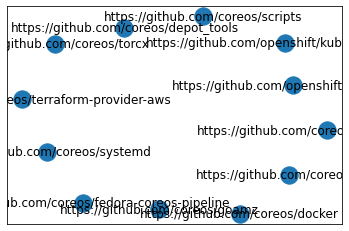

In [50]:
G = nx.from_pandas_edgelist(df_ok,
                            source='Git',
                            target='Git',
                            edge_attr=['Issue Authors', 'PR Creators', 'Commit Creators', 'PR Reviewers'],
                            create_using=nx.MultiGraph())
                            
nx.draw_networkx(G)

In [51]:
print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 12
Number of edges: 12
Average degree:   2.0000


* color code repos
* limit the repos
* example repos which are related